## Imports

In [305]:
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin

from feature_engine.imputation import AddMissingIndicator, CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OneHotEncoder,CountFrequencyEncoder,OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer,LabelEncoder,label_binarize

from sklearn.metrics import (accuracy_score, roc_auc_score,explained_variance_score,mean_squared_error,r2_score,average_precision_score, classification_report, roc_curve, auc, confusion_matrix, 
                     precision_recall_fscore_support,make_scorer, f1_score,precision_score,recall_score, ConfusionMatrixDisplay)
from sklearn.model_selection import GridSearchCV,KFold, cross_val_score
from scikitplot.metrics import plot_roc, plot_confusion_matrix, plot_precision_recall,plot_roc_curve

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [306]:
df = pd.read_csv('data.csv')


## Pipelines
Se crean variables para unificar y entrenar el modelo a ver si es cancer o no.

In [307]:
df["is_cancer"] = df["diagnostic"].apply(lambda x: 1 if x in ["BCC","MEL","SCC"] else 0)

In [308]:
df.columns

Index(['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father',
       'background_mother', 'age', 'pesticide', 'gender',
       'skin_cancer_history', 'cancer_history', 'has_piped_water',
       'has_sewage_system', 'fitspatrick', 'region', 'diameter_1',
       'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed',
       'elevation', 'img_id', 'biopsed', 'is_cancer'],
      dtype='object')

In [309]:
# la persona estuvo aca antes? Tuvo en esta parte del cuerpo antes? Que tuvo antes? -> me parece que va a overfitear con eso


x1 = df.drop(columns=["is_cancer", "diagnostic"]) 
y1 = df["is_cancer"]

class HadBeforeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, x:pd.DataFrame, y):
        self.patient_counts = x["patient_id"].value_counts()
        #x["had_here_before"] = x["patient_id"].apply(lambda x: self.patient_counts[x] -1  )
        return self
    def transform(self, x:pd.DataFrame):
        new_counts = x["patient_id"].value_counts()

        x["had_here_before"] = x["patient_id"].apply(lambda x: self.patient_counts.get(x,0)+ new_counts[x] -1   )
        return x
    
class HadThisPartBeforeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, x:pd.DataFrame, y):
        self.patient_region_counts = x.groupby(["patient_id", "region"]).size().unstack(fill_value=0).T.to_dict('dict')
        return self
    def transform(self, x:pd.DataFrame):
        new_counts = x.groupby(["patient_id", "region"]).size().unstack(fill_value=0).T.to_dict('dict')
        x["had_this_part_before"] = x.apply(lambda row: 1 if  new_counts[row["patient_id"]][row["region"]] + self.patient_region_counts.get(row["patient_id"],{}).get(row["region"],0)>=2 else 0, axis=1)
        return x
    


class NormalDistributionImputer(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None):
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # we will store the mean and std of the variables for prediction time
        self.param_dict_ = {}
        for var in self.variables:
            self.param_dict_[var] = {'mean': X[var].mean(), 'std': X[var].std()}
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            mu, std = self.param_dict_[feature]['mean'], self.param_dict_[feature]['std']
            X[feature] = X[feature].apply(lambda x: np.random.normal(loc=mu, scale=std) if pd.isnull(x) else x)
        return X


preguntas = Pipeline([
    ( "had_here_before", HadBeforeTransformer()),
    ( "had_this_part_before", HadThisPartBeforeTransformer()),

])

limpieza = Pipeline([
    ("dropear", FunctionTransformer(lambda x: x.drop(["img_id","lesion_id", "patient_id"], axis=1,))),
                     ("frequency", CountFrequencyEncoder(encoding_method='frequency',variables=["region"])),
                     ("missingIndicator",  AddMissingIndicator(variables=["smoke","drink","background_father",
                                                           "background_mother","pesticide","gender","skin_cancer_history",
                                                            "cancer_history", "has_piped_water","has_sewage_system",
                                                            "itch","grew","hurt","changed","bleed","elevation","fitspatrick","diameter_1","diameter_2","age"])),
                     ("fillNaNs", CategoricalImputer(imputation_method="missing", variables=["smoke","drink","background_father",
                                                           "background_mother","pesticide","gender","skin_cancer_history",
                                                            "cancer_history", "has_piped_water","has_sewage_system",
                                                            "itch","grew","hurt","changed","bleed","elevation"])),
                     ("ordinal", OrdinalEncoder(encoding_method="arbitrary", variables=["smoke","drink","background_father",
                                                           "background_mother","pesticide","gender","skin_cancer_history",
                                                            "cancer_history", "has_piped_water","has_sewage_system",
                                                            "itch","grew","hurt","changed","bleed","elevation"]))
                    ])
imputing = Pipeline([("imputar_numericas",NormalDistributionImputer(  variables= ["fitspatrick","diameter_1","diameter_2","age"]))])



pipe = Pipeline([("preguntas",preguntas), ("limpieza",limpieza), ("imputing",imputing)])


In [310]:
x1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   lesion_id            2298 non-null   int64  
 2   smoke                1494 non-null   object 
 3   drink                1494 non-null   object 
 4   background_father    1480 non-null   object 
 5   background_mother    1476 non-null   object 
 6   age                  2298 non-null   int64  
 7   pesticide            1494 non-null   object 
 8   gender               1494 non-null   object 
 9   skin_cancer_history  1494 non-null   object 
 10  cancer_history       1494 non-null   object 
 11  has_piped_water      1494 non-null   object 
 12  has_sewage_system    1494 non-null   object 
 13  fitspatrick          1494 non-null   float64
 14  region               2298 non-null   object 
 15  diameter_1           1494 non-null   f

In [311]:

x1,x1_test,y1,y1_test = train_test_split(x1,y1, test_size=0.2, random_state=42)
pipe.fit(x1,y1)
x1 = pipe.transform(x1)
x1_test = pipe.transform(x1_test)

c:\Users\ianda\anaconda3\envs\itba_apa_env\lib\site-packages\feature_engine\encoding\base_encoder.py:257: UserWarning: During the encoding, NaN values were introduced in the feature(s) background_mother.
  warnings.warn(


In [312]:
label_encoder = LabelEncoder()
y1 = label_encoder.fit_transform(y1)
y1_test= label_encoder.transform(y1_test)

## Modelos

In [313]:
ratio = float(np.sum(y1 == 0))*100 / np.sum(y1 == 1)

xgb = XGBClassifier(scale_pos_weight=ratio)
xgb.fit(x1,y1)
y1_pred = xgb.predict(x1_test)

xgb.score(x1_test,y1_test)


0.9347826086956522

In [208]:
eval("TRUE".title())

True

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

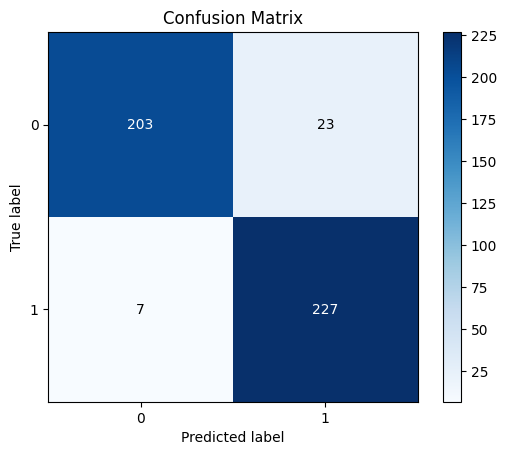

In [314]:
#Confusion matrix
plot_confusion_matrix(y1_test, y1_pred, normalize=False)

In [230]:
pipe = Pipeline([
    ("dropear", FunctionTransformer(lambda x: x.drop(["img_id","patient_id","lesion_id"], axis=1, errors='ignore'))),
    ("indicador_NAs",AddMissingIndicator(missing_only= True,variables = ["has_sewage_system","fitspatrick","diameter_1","diameter_2","skin_cancer_history","cancer_history","has_piped_water","background_father","background_mother","pesticide","smoke","drink"])),
    ("missing_categoricas",CategoricalImputer(variables = ["has_sewage_system","region","gender"])),
    ("encoding_onehot",OneHotEncoder(variables = ["region","gender"])),
    ("frequency_encoder", CountFrequencyEncoder(encoding_method='frequency',missing_values='ignore', variables=["background_father","background_mother"])),
    ("NaN_father",FunctionTransformer(lambda x: x.assign(background_father = x['background_father'].fillna(0)))),
    ("NaN_mother",FunctionTransformer(lambda x: x.assign(background_mother = x['background_mother'].fillna(0)))),
    ("tf_itch", FunctionTransformer(lambda x: x.assign(itch = x['itch'].apply(lambda x: 1 if x=="TRUE" else 0)))),
    ("tf_grew", FunctionTransformer(lambda x: x.assign(grew = x['grew'].apply(lambda x: 1 if x=="TRUE" else 0)))),
    ("tf_hurt", FunctionTransformer(lambda x: x.assign(hurt = x['hurt'].apply(lambda x: 1 if x=="TRUE" else 0)))),
    ("tf_changed", FunctionTransformer(lambda x: x.assign(changed = x['changed'].apply(lambda x: 1 if x=="TRUE" else 0)))),
    ("tf_bleed", FunctionTransformer(lambda x: x.assign(bleed = x['bleed'].apply(lambda x: 1 if x=="TRUE" else 0)))),
    ("tf_elevation", FunctionTransformer(lambda x: x.assign(elevation = x['elevation'].apply(lambda x: 1 if x=="TRUE" else 0)))),
    ("tf_biopsed",FunctionTransformer(lambda x: x.assign(biopsed = x['biopsed'].apply(lambda val: 1 if val else 0)))),
    ("tf_sewage", FunctionTransformer(lambda x: x.assign(has_sewage_system = x['has_sewage_system'].replace("Missing", False).fillna(False).astype(int).apply(lambda val: 1 if val else 0)))),
    ("tf_skin_cancer_history", FunctionTransformer(lambda x: x.assign(skin_cancer_history = x['skin_cancer_history'].replace("Missing", False).fillna(False).astype(int).apply(lambda val: 1 if val else 0)))),
    ("tf_cancer_history", FunctionTransformer(lambda x: x.assign(cancer_history = x['cancer_history'].replace("Missing", False).fillna(False).astype(int).apply(lambda val: 1 if val else 0)))),
    ("tf_pipedwater", FunctionTransformer(lambda x: x.assign(has_piped_water = x['has_piped_water'].replace("Missing", False).fillna(False).astype(int).apply(lambda val: 1 if val else 0)))),
    ("tf_pesticide", FunctionTransformer(lambda x: x.assign(pesticide = x['pesticide'].replace("Missing", False).fillna(False).astype(int).apply(lambda val: 1 if val else 0)))),
    ("tf_smoke", FunctionTransformer(lambda x: x.assign(smoke = x['smoke'].replace("Missing", False).fillna(False).astype(int).apply(lambda val: 1 if val else 0)))),
    ("tf_drink", FunctionTransformer(lambda x: x.assign(drink = x['drink'].replace("Missing", False).fillna(False).astype(int).apply(lambda val: 1 if val else 0)))),
    ("imputar_numericas",MeanMedianImputer( imputation_method = "median", variables= ["fitspatrick","diameter_1","diameter_2","age"])),
])

x1 = df.drop(columns=["is_cancer", "diagnostic"]) 
y1 = df["is_cancer"]

x1,x1_test,y1,y1_test = train_test_split(x1,y1, test_size=0.2, random_state=42)
pipe.fit(x1,y1)
x1 = pipe.transform(x1)
x1_test = pipe.transform(x1_test)

label_encoder = LabelEncoder()
y1 = label_encoder.fit_transform(y1)
y1_test= label_encoder.transform(y1_test)


c:\Users\ianda\anaconda3\envs\itba_apa_env\lib\site-packages\feature_engine\encoding\base_encoder.py:257: UserWarning: During the encoding, NaN values were introduced in the feature(s) background_father, background_mother.
  warnings.warn(
c:\Users\ianda\anaconda3\envs\itba_apa_env\lib\site-packages\feature_engine\encoding\base_encoder.py:257: UserWarning: During the encoding, NaN values were introduced in the feature(s) background_father, background_mother.
  warnings.warn(
c:\Users\ianda\anaconda3\envs\itba_apa_env\lib\site-packages\feature_engine\encoding\base_encoder.py:257: UserWarning: During the encoding, NaN values were introduced in the feature(s) background_father, background_mother.
  warnings.warn(


In [231]:




ratio = float(np.sum(y1 == 0)) / np.sum(y1 == 1)

xgb = XGBClassifier()
xgb.fit(x1,y1)
y1_pred = xgb.predict(x1_test)

xgb.score(x1_test,y1_test)



0.9260869565217391